In [1]:
#!pip install imblearn
#!pip install lazypredict
#!pip install researchpy

In [2]:
import numpy as np
import pandas as pd


import seaborn as sns
from plotnine import *
import matplotlib.pyplot as plt

### Cross validation
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import *

import random 
from tqdm.notebook import *

import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

from imblearn.combine import SMOTETomek

# Importation des données

In [3]:
#Base train
train = pd.read_csv("train.csv")
train.head(3)

,id,date,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
0,0,2012-12-12,blond,23.0,9.0,43596.0,M,licence,forage,96.56,oui,1
1,1,2011-03-16,blond,35.0,13.0,29992.0,M,master,forage,84.68,non,1
2,2,2014-10-05,chatain,55.0,9.0,33332.0,F,master,detective,60.84,non,1


In [4]:
#Base Test
test = pd.read_csv("test.csv")
test.head(3)

,id,date,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo
0,0,2012-06-02,roux,25.0,9.0,26803.0,F,licence,geologie,97.08,non
1,1,2011-04-21,blond,35.0,13.0,38166.0,M,licence,forage,63.86,non
2,2,2012-09-07,blond,29.0,13.0,35207.0,M,licence,geologie,78.50,non


In [5]:
#Fusion train/test
data = pd.concat([train,test], axis = 0,ignore_index=True)
data.tail()

,id,date,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
19995,4995,2010-06-11,roux,17.0,11.0,31145.0,F,licence,forage,97.61,non,NaN
19996,4996,2010-04-19,brun,23.0,15.0,26048.0,M,master,geologie,79.17,non,NaN
19997,4997,2014-03-05,chatain,39.0,10.0,35497.0,F,master,forage,62.52,non,NaN
19998,4998,2014-01-10,chatain,37.0,14.0,31001.0,M,doctorat,forage,72.00,oui,NaN
19999,4999,2014-06-07,chatain,30.0,6.0,30154.0,F,master,forage,96.01,non,NaN


# EDA

In [6]:
data.shape

(20000, 12)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          20000 non-null  int64  
 1   date        19909 non-null  object 
 2   cheveux     19897 non-null  object 
 3   age         19909 non-null  float64
 4   exp         19904 non-null  float64
 5   salaire     19905 non-null  float64
 6   sexe        19900 non-null  object 
 7   diplome     19890 non-null  object 
 8   specialite  19907 non-null  object 
 9   note        19886 non-null  float64
 10  dispo       19894 non-null  object 
 11  embauche    15000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 1.8+ MB


# Data Management 

**Suppression de variables**

In [8]:
# Suppression des colonnes
data.drop(['date'], axis=1,inplace=True)

### Valeurs manquantes

In [9]:
data.isna().sum()

id               0
cheveux        103
age             91
exp             96
salaire         95
sexe           100
diplome        110
specialite      93
note           114
dispo          106
embauche      5000
dtype: int64

In [10]:
#Remplace les valeurs manquantes des variables quantitatives par 
data["age"].fillna(value=data["age"].median(),inplace=True)
data["exp"].fillna(value=data["exp"].median(),inplace=True)
data["salaire"].fillna(value=data["salaire"].median(),inplace=True)
data["note"].fillna(value=data["note"].median(),inplace=True)

In [11]:
mode = data.filter(["cheveux", "sexe","diplome", "specialite","dispo"]).mode()
data[["cheveux", "sexe","diplome", "specialite","dispo"]]= data[["cheveux", "sexe","diplome", "specialite","dispo"]].fillna(value=mode.iloc[0])

In [12]:
data.isna().sum()

id               0
cheveux          0
age              0
exp              0
salaire          0
sexe             0
diplome          0
specialite       0
note             0
dispo            0
embauche      5000
dtype: int64

### Outliers

Recherche des outliers

Note

<AxesSubplot:>

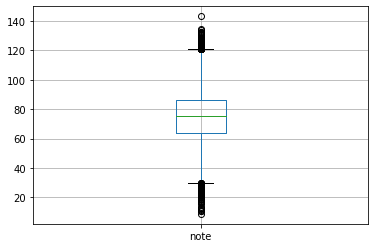

In [13]:
data.boxplot(column='note', return_type='axes')

In [14]:
data["note"].describe()

count    20000.000000
mean        75.168256
std         17.047132
min          8.680000
25%         63.807500
50%         75.080000
75%         86.550000
max        143.220000
Name: note, dtype: float64

In [15]:
#Les notes allant de 0 à 100, toutes les note supérieures à 100 sont ramenées à 100
for i in range(len(data.index)):
    if data.loc[data['note'].index[i],'note']>100:
        data.loc[data['note'].index[i],'note']=100

Age

<AxesSubplot:>

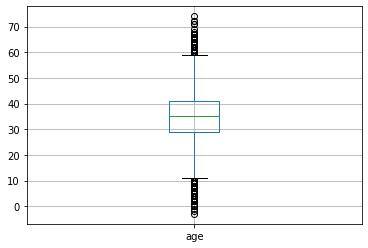

In [16]:
data.boxplot(column='age', return_type='axes')

In [17]:
# Les ages superieurs à 66 sont ramenés à 66 ans et ceux inférieur à 18 sont ramenés à 18 ans
for i in range(len(data.index)):
    if data.loc[data['age'].index[i],'age']>66:
        data.loc[data['age'].index[i],'age']=66
        
for i in range(len(data.index)):
    if data.loc[data['age'].index[i],'age']<16:
        data.loc[data['age'].index[i],'age']=16

Exp

<AxesSubplot:>

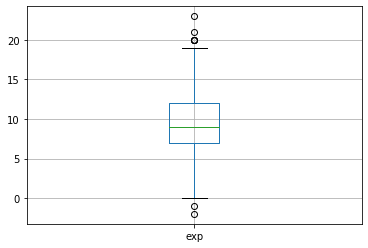

In [18]:
data.boxplot(column='exp', return_type='axes')

In [19]:
for i in range(len(data.index)):
    if data.loc[data['exp'].index[i],'exp']<0:
        data.loc[data['exp'].index[i],'exp']=0

In [20]:
#Matrice de corrélation avec Nombre intégré
#correlation = df.corr(method='pearson')
#plt.figure(figsize=(8,6))
#sns.heatmap(correlation, annot=True)
#plt.show()

**Dépendance entre la spécialité et le sexe ?**

In [21]:
import researchpy

In [22]:
#Etude de la liasison entre deux variables quali
#Test de khi-Deux
print("H0:Les variables sont indépendantes \nH1:Les variables sont dépendantes \n\n")
crosstab, res, exp = researchpy.crosstab(data['specialite'], data['sexe'], test='chi-square', expected_freqs=True)
print(f"Tableau de contingence \n{exp} \n\n {res},")
print("\n\n\n")

H0:Les variables sont indépendantes 
H1:Les variables sont dépendantes 


Tableau de contingence 
                   sexe            
sexe                  F           M
specialite                         
archeologie   554.36120   829.63880
detective    1664.28525  2490.71475
forage       1738.38700  2601.61300
geologie     4053.96655  6067.03345 

                 Chi-square test    results
0  Pearson Chi-square ( 3.0) =   2687.4497
1                    p-value =      0.0000
2                 Cramer's V =      0.3666,






**Commentaire:** la p-value est inférieure à 5%, il y'a dépendance statistique entre la spécialité et les sexe, cependant cette dépendance est faible car le V de Cramer est de 36,97%.

**La couleur de cheveux et le salaire demandé?**

In [23]:
import statsmodels.api 

In [24]:
#Liaison entre une variable quantitative et une qualitative
#Anova One Way
print("𝐻0=𝑋 𝑞𝑢𝑎𝑛𝑡𝑖𝑡𝑎𝑡𝑖𝑣𝑒,𝑌 𝑐𝑎𝑡é𝑔𝑜𝑟𝑖𝑒𝑙𝑙𝑒 𝑠𝑜𝑛𝑡 𝑖𝑛𝑑é𝑝𝑒𝑛𝑑𝑎𝑛𝑡𝑒𝑠  \n𝐻1=𝑋 𝑞𝑢𝑎𝑛𝑡𝑖𝑡𝑎𝑡𝑖𝑣𝑒,𝑌 𝑐𝑎𝑡é𝑔𝑜𝑟𝑖𝑒𝑙𝑙𝑒 𝑠𝑜𝑛𝑡 𝑑é𝑝𝑒𝑛𝑑𝑎𝑛𝑡𝑒𝑠")
resultat=statsmodels.formula.api.ols('salaire ~ cheveux',data=data).fit() #modèle ANOVA
table=statsmodels.api.stats.anova_lm(resultat)
table

𝐻0=𝑋 𝑞𝑢𝑎𝑛𝑡𝑖𝑡𝑎𝑡𝑖𝑣𝑒,𝑌 𝑐𝑎𝑡é𝑔𝑜𝑟𝑖𝑒𝑙𝑙𝑒 𝑠𝑜𝑛𝑡 𝑖𝑛𝑑é𝑝𝑒𝑛𝑑𝑎𝑛𝑡𝑒𝑠  
𝐻1=𝑋 𝑞𝑢𝑎𝑛𝑡𝑖𝑡𝑎𝑡𝑖𝑣𝑒,𝑌 𝑐𝑎𝑡é𝑔𝑜𝑟𝑖𝑒𝑙𝑙𝑒 𝑠𝑜𝑛𝑡 𝑑é𝑝𝑒𝑛𝑑𝑎𝑛𝑡𝑒𝑠


,df,sum_sq,mean_sq,F,PR(>F)
cheveux,3.0,2.186304e+09,7.287679e+08,29.378098,6.058342e-19
Residual,19996.0,4.960308e+11,2.480650e+07,NaN,NaN


**Commentaire:** la p-value est inférieure à 5% (4.927634e-19), il y 'a une dépendance entre les cheveux et le salaire.

**Le nombre d’années d’expérience et la note à l’exercice ?**

In [25]:
import matplotlib.pyplot as plt

In [26]:
import scipy

In [27]:
print("𝐻0=𝑋,𝑌 𝑛𝑒 𝑠𝑜𝑛𝑡 𝑝𝑎𝑠 𝑐𝑜𝑟𝑟é𝑙é𝑒𝑠 \n𝐻1=𝑋,𝑌 𝑠𝑜𝑛𝑡 𝑐𝑜𝑟𝑟é𝑙é𝑒𝑠")
scipy.stats.pearsonr(data['exp'],data['note'])

𝐻0=𝑋,𝑌 𝑛𝑒 𝑠𝑜𝑛𝑡 𝑝𝑎𝑠 𝑐𝑜𝑟𝑟é𝑙é𝑒𝑠 
𝐻1=𝑋,𝑌 𝑠𝑜𝑛𝑡 𝑐𝑜𝑟𝑟é𝑙é𝑒𝑠


(-0.013346590919841073, 0.05909860572494639)

**Commentaire:** la p-value est supérieure à 5%,alors la note et l'expérience ne sont pas corrélés.

In [28]:
# boucle pour le test de Khi 2
#print("H0:Les variables sont indépendantes \nH1:Les variables sont dépendantes \n\n")
#for i in cat1.columns:
 # if i != 'embauche':
  #  crosstab, res, exp = researchpy.crosstab(cat[i], target, test='chi-square', expected_freqs=True)
   # print(f"{i} / embauche\n")
   # print(f"Tableau de contingence \n{exp} \n\n {res},")
 #   print("\n\n\n")

In [29]:
#resultat=statsmodels.formula.api.ols('age ~ embauche',data=num1).fit() #modèle ANOVA
#table=statsmodels.api.stats.anova_lm(resultat)
#table

**Scission de la base en train et test**

In [31]:
data['diplome'].replace(["doctorat","master","licence","bac"], [4,3,2,1], inplace=True)
data.head()

,id,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
0,0,blond,23.0,9.0,43596.0,M,2,forage,96.56,oui,1.0
1,1,blond,35.0,13.0,29992.0,M,3,forage,84.68,non,1.0
2,2,chatain,55.0,9.0,33332.0,F,3,detective,60.84,non,1.0
3,3,brun,33.0,10.0,36944.0,M,3,geologie,80.34,oui,1.0
4,4,blond,28.0,13.0,39489.0,M,3,geologie,91.94,oui,1.0


In [33]:
data['diplome'] = data['diplome'].astype(float)

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          20000 non-null  int64  
 1   cheveux     20000 non-null  object 
 2   age         20000 non-null  float64
 3   exp         20000 non-null  float64
 4   salaire     20000 non-null  float64
 5   sexe        20000 non-null  object 
 6   diplome     20000 non-null  float64
 7   specialite  20000 non-null  object 
 8   note        20000 non-null  float64
 9   dispo       20000 non-null  object 
 10  embauche    15000 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.7+ MB


In [35]:
Test = data[data.isna().any(axis=1)]
Test

,id,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
15000,0,roux,25.0,9.0,26803.0,F,2.0,geologie,97.08,non,NaN
15001,1,blond,35.0,13.0,38166.0,M,2.0,forage,63.86,non,NaN
15002,2,blond,29.0,13.0,35207.0,M,2.0,geologie,78.50,non,NaN
15003,3,brun,35.0,12.0,32442.0,M,2.0,geologie,45.09,non,NaN
15004,4,roux,35.0,6.0,28533.0,F,2.0,detective,81.91,non,NaN
...,...,...,...,...,...,...,...,...,...,...,...
19995,4995,roux,17.0,11.0,31145.0,F,2.0,forage,97.61,non,NaN
19996,4996,brun,23.0,15.0,26048.0,M,3.0,geologie,79.17,non,NaN
19997,4997,chatain,39.0,10.0,35497.0,F,3.0,forage,62.52,non,NaN
19998,4998,chatain,37.0,14.0,31001.0,M,4.0,forage,72.00,oui,NaN


In [36]:
Test.drop(['embauche'], axis=1,inplace=True)
Test

,id,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo
15000,0,roux,25.0,9.0,26803.0,F,2.0,geologie,97.08,non
15001,1,blond,35.0,13.0,38166.0,M,2.0,forage,63.86,non
15002,2,blond,29.0,13.0,35207.0,M,2.0,geologie,78.50,non
15003,3,brun,35.0,12.0,32442.0,M,2.0,geologie,45.09,non
15004,4,roux,35.0,6.0,28533.0,F,2.0,detective,81.91,non
...,...,...,...,...,...,...,...,...,...,...
19995,4995,roux,17.0,11.0,31145.0,F,2.0,forage,97.61,non
19996,4996,brun,23.0,15.0,26048.0,M,3.0,geologie,79.17,non
19997,4997,chatain,39.0,10.0,35497.0,F,3.0,forage,62.52,non
19998,4998,chatain,37.0,14.0,31001.0,M,4.0,forage,72.00,oui


In [37]:
Train =data.dropna()
Train

,id,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
0,0,blond,23.0,9.0,43596.0,M,2.0,forage,96.56,oui,1.0
1,1,blond,35.0,13.0,29992.0,M,3.0,forage,84.68,non,1.0
2,2,chatain,55.0,9.0,33332.0,F,3.0,detective,60.84,non,1.0
3,3,brun,33.0,10.0,36944.0,M,3.0,geologie,80.34,oui,1.0
4,4,blond,28.0,13.0,39489.0,M,3.0,geologie,91.94,oui,1.0
...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,roux,47.0,9.0,35723.0,M,2.0,geologie,66.47,non,0.0
14996,14996,chatain,38.0,10.0,33570.0,F,3.0,geologie,62.29,non,1.0
14997,14997,chatain,23.0,6.0,33751.0,F,4.0,detective,100.00,oui,0.0
14998,14998,chatain,33.0,11.0,34167.0,F,2.0,detective,73.35,non,0.0


**Encoding des variables catégorielles**

In [38]:
Train.drop(['id'], axis=1,inplace=True)

In [39]:
Train.head()

,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
0,blond,23.0,9.0,43596.0,M,2.0,forage,96.56,oui,1.0
1,blond,35.0,13.0,29992.0,M,3.0,forage,84.68,non,1.0
2,chatain,55.0,9.0,33332.0,F,3.0,detective,60.84,non,1.0
3,brun,33.0,10.0,36944.0,M,3.0,geologie,80.34,oui,1.0
4,blond,28.0,13.0,39489.0,M,3.0,geologie,91.94,oui,1.0


In [40]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 14999
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   cheveux     15000 non-null  object 
 1   age         15000 non-null  float64
 2   exp         15000 non-null  float64
 3   salaire     15000 non-null  float64
 4   sexe        15000 non-null  object 
 5   diplome     15000 non-null  float64
 6   specialite  15000 non-null  object 
 7   note        15000 non-null  float64
 8   dispo       15000 non-null  object 
 9   embauche    15000 non-null  float64
dtypes: float64(6), object(4)
memory usage: 1.3+ MB


In [41]:
cat = Train.select_dtypes(include=['object'])
num = Train.select_dtypes(include=['float64']).drop("embauche", axis=1)

In [42]:
num.head()

,age,exp,salaire,diplome,note
0,23.0,9.0,43596.0,2.0,96.56
1,35.0,13.0,29992.0,3.0,84.68
2,55.0,9.0,33332.0,3.0,60.84
3,33.0,10.0,36944.0,3.0,80.34
4,28.0,13.0,39489.0,3.0,91.94


In [43]:
cat.head()

,cheveux,sexe,specialite,dispo
0,blond,M,forage,oui
1,blond,M,forage,non
2,chatain,F,detective,non
3,brun,M,geologie,oui
4,blond,M,geologie,oui


In [44]:
train["specialite"].value_counts()

geologie       7505
forage         3261
detective      3123
archeologie    1038
Name: specialite, dtype: int64

In [45]:
cat = pd.get_dummies(cat)

In [46]:
cat

,cheveux_blond,cheveux_brun,cheveux_chatain,cheveux_roux,sexe_F,sexe_M,specialite_archeologie,specialite_detective,specialite_forage,specialite_geologie,dispo_non,dispo_oui
0,1,0,0,0,0,1,0,0,1,0,0,1
1,1,0,0,0,0,1,0,0,1,0,1,0
2,0,0,1,0,1,0,0,1,0,0,1,0
3,0,1,0,0,0,1,0,0,0,1,0,1
4,1,0,0,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0,0,0,1,0,1,0,0,0,1,1,0
14996,0,0,1,0,1,0,0,0,0,1,1,0
14997,0,0,1,0,1,0,0,1,0,0,0,1
14998,0,0,1,0,1,0,0,1,0,0,1,0


In [47]:
target = Train [["embauche"]]

In [48]:
target

,embauche
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
14995,0.0
14996,1.0
14997,0.0
14998,0.0


In [49]:
target["embauche"].value_counts(normalize = True)

0.0    0.8854
1.0    0.1146
Name: embauche, dtype: float64

# Etude des correlations avec la variable target

In [ ]:
import researchpy

### Correlation entre la target et les variables qualitatives

**Variables catégorielle pertinentes selon le test de Chi-Deux : Liaison, Cheveux, Diplome, Specialite**

### Correlation entre la target et les variables quantitatives

### Etude de la liaison entre les variables features

***Variables retenues pour le modèle***

***Features et de la target***

In [50]:
features = pd.concat([cat,num], axis = 1)
features # faut-il normaliser/min max scaller les var quant pour une meilleure regression?

,cheveux_blond,cheveux_brun,cheveux_chatain,cheveux_roux,sexe_F,sexe_M,specialite_archeologie,specialite_detective,specialite_forage,specialite_geologie,dispo_non,dispo_oui,age,exp,salaire,diplome,note
0,1,0,0,0,0,1,0,0,1,0,0,1,23.0,9.0,43596.0,2.0,96.56
1,1,0,0,0,0,1,0,0,1,0,1,0,35.0,13.0,29992.0,3.0,84.68
2,0,0,1,0,1,0,0,1,0,0,1,0,55.0,9.0,33332.0,3.0,60.84
3,0,1,0,0,0,1,0,0,0,1,0,1,33.0,10.0,36944.0,3.0,80.34
4,1,0,0,0,0,1,0,0,0,1,0,1,28.0,13.0,39489.0,3.0,91.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0,0,0,1,0,1,0,0,0,1,1,0,47.0,9.0,35723.0,2.0,66.47
14996,0,0,1,0,1,0,0,0,0,1,1,0,38.0,10.0,33570.0,3.0,62.29
14997,0,0,1,0,1,0,0,1,0,0,0,1,23.0,6.0,33751.0,4.0,100.00
14998,0,0,1,0,1,0,0,1,0,0,1,0,33.0,11.0,34167.0,2.0,73.35


# SMOTE

In [51]:
# premiere valeur sampling_strategy=0.92
smotetomek_X = features
smotetomek_Y = target

smote_tomek = SMOTETomek(random_state=42, sampling_strategy=0.92) #0.5 = embauche_1 == 50% ebauche_0
X_resampled, y_resampled = smote_tomek.fit_resample(features,target)

smotetomek_X = pd.DataFrame(data = X_resampled,columns=features.columns)
smotetomek_Y = pd.DataFrame(data = y_resampled,columns=["embauche"])
print ((smotetomek_Y['embauche'] == 0).sum())
print ((smotetomek_Y['embauche'] == 1).sum())

12663
11600


In [52]:
smotetomek_Y['embauche'].value_counts()

0.0    12663
1.0    11600
Name: embauche, dtype: int64

In [53]:
smotetomek_Y["embauche"].value_counts(normalize = True)

0.0    0.521906
1.0    0.478094
Name: embauche, dtype: float64

In [54]:
smotetomek_X.head(3)

,cheveux_blond,cheveux_brun,cheveux_chatain,cheveux_roux,sexe_F,sexe_M,specialite_archeologie,specialite_detective,specialite_forage,specialite_geologie,dispo_non,dispo_oui,age,exp,salaire,diplome,note
0,1,0,0,0,0,1,0,0,1,0,0,1,23.0,9.0,43596.0,2.0,96.56
1,1,0,0,0,0,1,0,0,1,0,1,0,35.0,13.0,29992.0,3.0,84.68
2,0,0,1,0,1,0,0,1,0,0,1,0,55.0,9.0,33332.0,3.0,60.84


### Choix du modèle

In [55]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

In [56]:
X_train, X_test, y_train, y_test = train_test_split(smotetomek_X, smotetomek_Y,test_size=0.1,random_state =123)

In [ ]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)

In [ ]:
from sklearn.feature_selection import RFECV

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model = RandomForestClassifier()
rfecv = RFECV(estimator=model,cv=5,scoring='neg_mean_squared_error')   ## on peut choisir le min_features_to_select( 1 par défaut)
rfecv = rfecv.fit(X_train, y_train)

print('Nombre optimal de varibales :', rfecv.n_features_)
print('Les meilleures variables :', X_train.columns[rfecv.support_])
best_features = list(X_train.columns[rfecv.support_])

In [ ]:
#from xgboost import XGBClassifier

In [ ]:
model = XGBClassifier()
rfecv = RFECV(estimator=model,cv=5,scoring='neg_mean_squared_error')   ## on peut choisir le min_features_to_select( 1 par défaut)
rfecv = rfecv.fit(X_train, y_train)

print('Nombre optimal de varibales :', rfecv.n_features_)
print('Les meilleures variables :', X_train.columns[rfecv.support_])
best_features = list(X_train.columns[rfecv.support_])

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(features, target,test_size=0.1,random_state =123)

In [ ]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train1, X_test1, y_train1, y_test1)
print(models)

In [ ]:
from sklearn.utils import resample

In [ ]:
#X2 = Train
#minority = X2[X2.embauche == 1]
#majority = X2[X2.embauche == 0]
#minority_upsampled = resample(minority, replace=True, n_samples = len(majority))
#minority_upsampled
"majority.shape

In [ ]:
minority_upsampled.shape

In [ ]:
upsampled=pd.concat([majority, minority_upsampled])
upsampled


In [ ]:
X_train_up=upsampled.drop('embauche',axis=1)
y_train_up=upsampled['embauche']

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(cat, y_train_up,test_size=0.1,random_state =123)

In [ ]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train2, X_test2, y_train2, y_test2)
print(models)

## Essai

In [ ]:
X_train_up
cat=X_train_up.select_dtypes(include=['object'])
cat

In [ ]:
cat = pd.get_dummies(cat)
cat

In [ ]:
y_train_up

# Regression Logistic

In [57]:
# Modélisation de l'algorithme Random Forest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_jobs=-1)

In [58]:
#Entrainement du modèle
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [59]:
#prédiction
y_pred=model.predict_proba(X_train) #predict_proba

In [60]:
pred_train_proba1 = y_pred[:,1]

In [61]:
from sklearn.metrics import roc_auc_score

In [62]:
roc_auc_score(y_train,pred_train_proba1)

1.0

### ---------------------------------------------------------------------------

In [ ]:
# Modélisation de l'algorithme Random Forest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_jobs=-1)

In [ ]:
#Entrainement du modèle
model.fit(smotetomek_X, smotetomek_Y)

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid ={"min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [5, 20, 100],
            'n_estimators': [200, 500],
            'max_features': ['auto', 'sqrt', 'log2'],
            #'max_depth' : [4,5,6,7,8],
            #'criterion' :['gini', 'entropy']
}

grid_cv = GridSearchCV(model,param_grid,cv=3)
grid_cv.fit(smotetomek_X, smotetomek_Y)

In [ ]:
print(" Résultat du Grid Search " )
print("\n Le nombre d'estimators optimal:\n",grid_cv.best_estimator_)
print("\n Le meilleur score obtenu:\n",grid_cv.best_score_)
print("\n Les meilleurs paramètres:\n",grid_cv.best_params_)

In [ ]:
# Modélisation de l'algorithme Random Forest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=8, max_leaf_nodes=100, min_samples_leaf=20,
                       min_samples_split=40, n_jobs=-1)

In [ ]:
model.fit(smotetomek_X, smotetomek_Y)

In [ ]:
#RandomForestClassifier(max_depth=8, max_leaf_nodes=100, min_samples_leaf=20,
                       min_samples_split=40, n_jobs=-1) Meilleurs para

In [ ]:
#prédiction
y_pred=model.predict_proba(smotetomek_X) #predict_proba

In [ ]:
pred_train_proba1 = y_pred[:,1]

In [ ]:
roc_auc_score(smotetomek_Y,pred_train_proba1)
#lr = LogisticRegression()
#pred_train_classe = lr.predict(train[FEATURES])
#pred_train_proba = lr.predict_proba(train[FEATURES])
#pred_train_proba = pred_train_proba[:,1]
#roc_auc_score(train[TARGET],pred_train_proba)


# Partie Test Random Forest

In [ ]:
pred_test_proba = RandomForestClassifier.predict_proba(features1)
pred_test_proba2 = pred_test_proba[:,1]

In [ ]:
pred_test_proba2

In [ ]:
test['embauche'] = pred_test_proba2

In [ ]:
test[["id","embauche"]].to_csv('submission_regression_logitique10.csv',index=False)

In [ ]:
y_pred=model.predict_proba(features) #predict_proba

In [ ]:
pred_train_proba1 = y_pred[:,1]

In [ ]:
roc_auc_score(target,pred_train_proba1)

**Regression logistique**

In [ ]:
#clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
#models,predictions = clf.fit(X_train, X_test, y_train, y_test)
#print(models)

# Data management test

In [63]:
cat1 = Test.select_dtypes(include=['object'])
num1 = Test.select_dtypes(include=['float64'])

In [64]:
cat1

,cheveux,sexe,specialite,dispo
15000,roux,F,geologie,non
15001,blond,M,forage,non
15002,blond,M,geologie,non
15003,brun,M,geologie,non
15004,roux,F,detective,non
...,...,...,...,...
19995,roux,F,forage,non
19996,brun,M,geologie,non
19997,chatain,F,forage,non
19998,chatain,M,forage,oui


In [65]:
num1

,age,exp,salaire,diplome,note
15000,25.00,9.00,26803.00,2.00,97.08
15001,35.00,13.00,38166.00,2.00,63.86
15002,29.00,13.00,35207.00,2.00,78.50
15003,35.00,12.00,32442.00,2.00,45.09
15004,35.00,6.00,28533.00,2.00,81.91
...,...,...,...,...,...
19995,17.00,11.00,31145.00,2.00,97.61
19996,23.00,15.00,26048.00,3.00,79.17
19997,39.00,10.00,35497.00,3.00,62.52
19998,37.00,14.00,31001.00,4.00,72.00


In [66]:
cat1 = pd.get_dummies(cat1)

In [67]:
cat1

,cheveux_blond,cheveux_brun,cheveux_chatain,cheveux_roux,sexe_F,sexe_M,specialite_archeologie,specialite_detective,specialite_forage,specialite_geologie,dispo_non,dispo_oui
15000,0,0,0,1,1,0,0,0,0,1,1,0
15001,1,0,0,0,0,1,0,0,1,0,1,0
15002,1,0,0,0,0,1,0,0,0,1,1,0
15003,0,1,0,0,0,1,0,0,0,1,1,0
15004,0,0,0,1,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0,0,0,1,1,0,0,0,1,0,1,0
19996,0,1,0,0,0,1,0,0,0,1,1,0
19997,0,0,1,0,1,0,0,0,1,0,1,0
19998,0,0,1,0,0,1,0,0,1,0,0,1


In [68]:
features1 = pd.concat([cat1,num1], axis = 1)

In [69]:
features1

,cheveux_blond,cheveux_brun,cheveux_chatain,cheveux_roux,sexe_F,sexe_M,specialite_archeologie,specialite_detective,specialite_forage,specialite_geologie,dispo_non,dispo_oui,age,exp,salaire,diplome,note
15000,0,0,0,1,1,0,0,0,0,1,1,0,25.00,9.00,26803.00,2.00,97.08
15001,1,0,0,0,0,1,0,0,1,0,1,0,35.00,13.00,38166.00,2.00,63.86
15002,1,0,0,0,0,1,0,0,0,1,1,0,29.00,13.00,35207.00,2.00,78.50
15003,0,1,0,0,0,1,0,0,0,1,1,0,35.00,12.00,32442.00,2.00,45.09
15004,0,0,0,1,1,0,0,1,0,0,1,0,35.00,6.00,28533.00,2.00,81.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0,0,0,1,1,0,0,0,1,0,1,0,17.00,11.00,31145.00,2.00,97.61
19996,0,1,0,0,0,1,0,0,0,1,1,0,23.00,15.00,26048.00,3.00,79.17
19997,0,0,1,0,1,0,0,0,1,0,1,0,39.00,10.00,35497.00,3.00,62.52
19998,0,0,1,0,0,1,0,0,1,0,0,1,37.00,14.00,31001.00,4.00,72.00


In [70]:
pred_test_proba = model.predict_proba(features1)
pred_test_proba1 = pred_test_proba[:,1]

In [71]:
pred_test_proba1

array([0.05, 0.02, 0.22, ..., 0.28, 0.03, 0.  ])

In [72]:
test['embauche'] = pred_test_proba1

In [73]:
test[["id","embauche"]].to_csv('submission_regression_logitique11.csv',index=False)